# **Stroke Prediction Model**

## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('./train_strokes.csv')
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [3]:
# uniform format
df.columns = df.columns.str.lower()

# check for duplicate data based on ['id']
df.duplicated('id').sum()

0

In [4]:
# feature ['id'] is not needed for analysis
df.drop(['id'], axis=1, inplace=True)
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [5]:
#check for missing values
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [6]:
# reassign missing values of ['smoking_status'] as 'unknown' instead of dropping them
df['smoking_status'].fillna('unknown', inplace=True)
df['smoking_status'].value_counts()

smoking_status
never smoked       16053
unknown            13292
formerly smoked     7493
smokes              6562
Name: count, dtype: int64

In [7]:
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = df.columns.drop(numeric_cols)

# check unique values of categorical variables
for col in df[categorical_cols]:
    print(f'{col} : {df[col].unique()}')

gender : ['Male' 'Female' 'Other']
hypertension : [0 1]
heart_disease : [0 1]
ever_married : ['No' 'Yes']
work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
residence_type : ['Rural' 'Urban']
smoking_status : ['unknown' 'never smoked' 'formerly smoked' 'smokes']
stroke : [0 1]


In [8]:
# check values in ['gender']
print(df['gender'].value_counts())

# drop 'Other' due to insufficient data
df = df[df['gender']!='Other']
df['gender'].value_counts()

gender
Female    25665
Male      17724
Other        11
Name: count, dtype: int64


gender
Female    25665
Male      17724
Name: count, dtype: int64

count    41931.000000
mean        28.605156
std          7.770186
min         10.100000
25%         23.200000
50%         27.700000
75%         32.900000
max         97.600000
Name: bmi, dtype: float64

median: 27.7


<Axes: xlabel='bmi'>

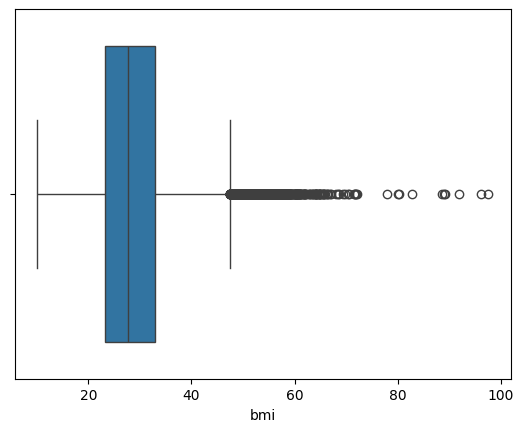

In [9]:
# visualization of ['bmi']
import seaborn as sns

print(df['bmi'].describe())

# considering outliers, replace missing values with median
median = df['bmi'].median()
print(f'\nmedian: {median}')
sns.boxplot(x=df['bmi'])

In [10]:
# replace missing data in ['bmi'] with median
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# check missing data
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [25]:
# check ratio of target feature ['stroke']
print(df.stroke.value_counts(), df.stroke.value_counts(normalize=True), sep='\n\n')

# imbalanced target class

stroke
0    42606
1      783
Name: count, dtype: int64

stroke
0    0.981954
1    0.018046
Name: proportion, dtype: float64


## Data Visualization

### Stroke by Age, Average Glucose Level, and BMI

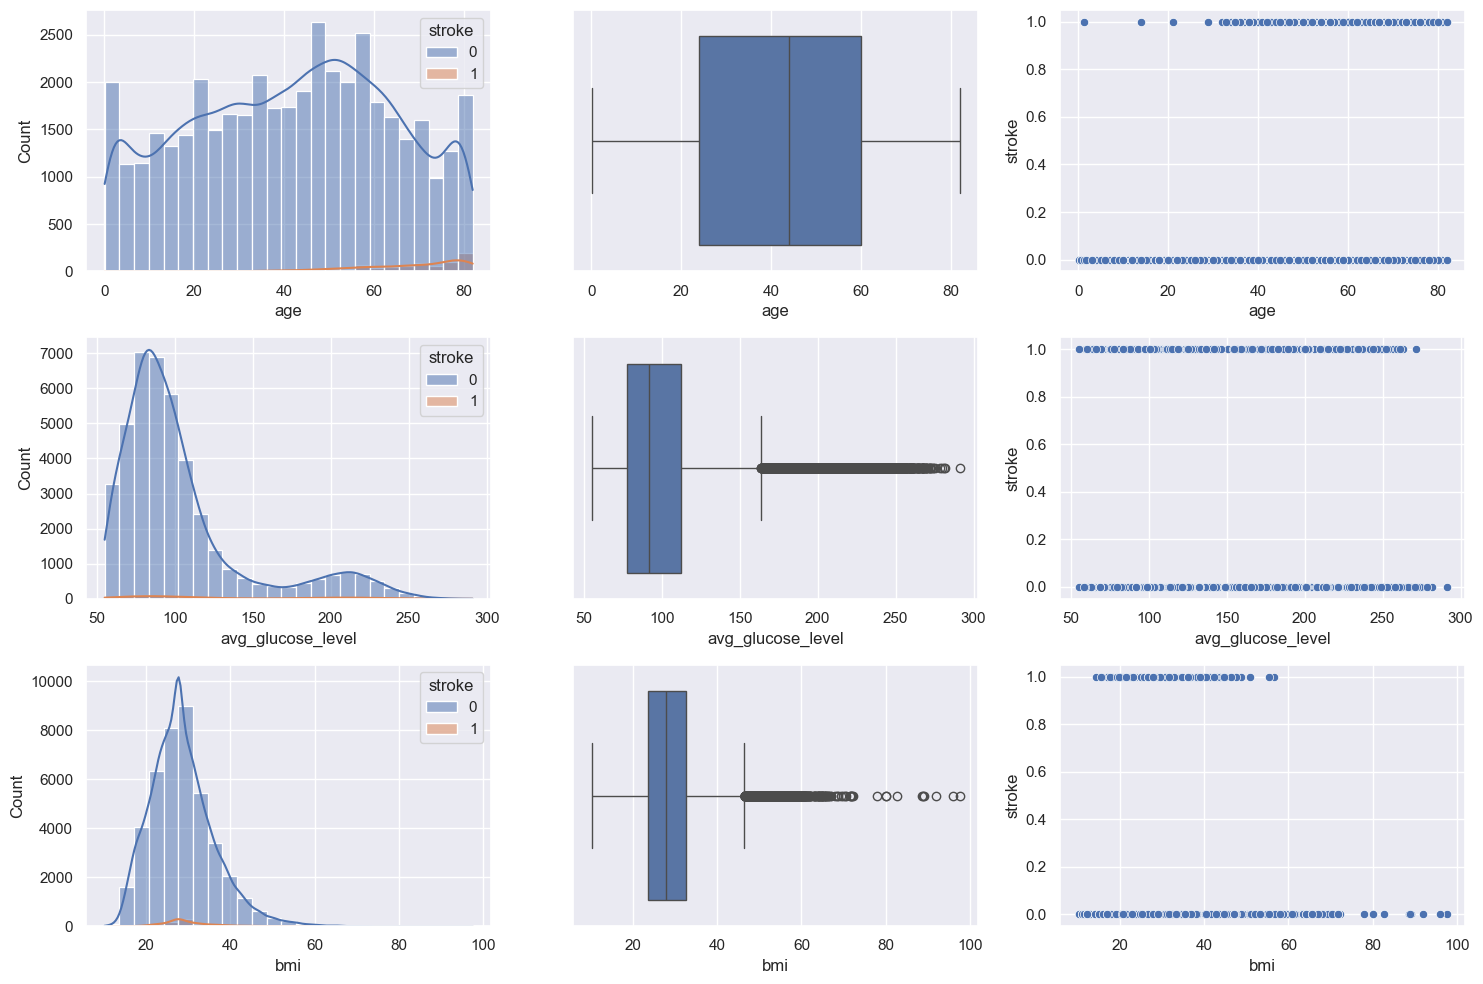

In [29]:
import matplotlib.pyplot as plt

# numeric_cols = ['age', 'avg_glucose_level', 'bmi']
# categorical_cols = df.columns.drop(numeric_cols)

fig, axs = plt.subplots(3, 3, figsize=(15,10))
sns.set_theme()

for i, col in enumerate(numeric_cols):
    sns.histplot(df, x=col, hue='stroke', kde=True, bins=25, fill=True, ax=axs[i, 0])
    sns.boxplot(df, x=col, ax=axs[i, 1], )
    sns.scatterplot(df, x=col, y='stroke', ax=axs[i,2])

plt.tight_layout()

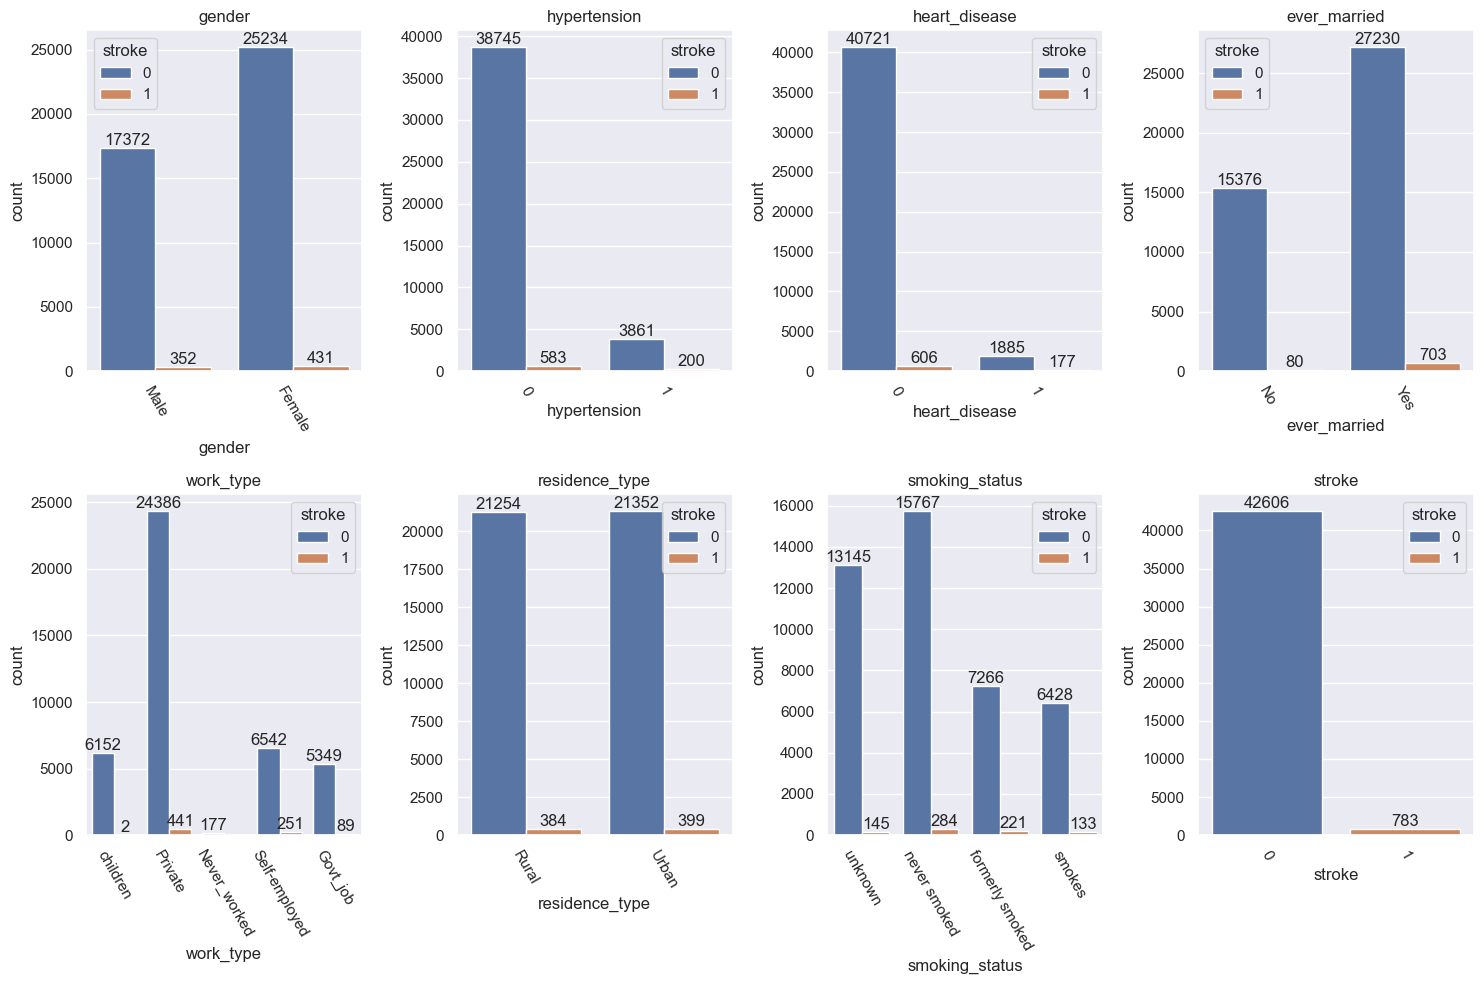

In [28]:
# numeric_cols = ['age', 'avg_glucose_level', 'bmi']
# categorical_cols = df.columns.drop(numeric_cols)

fig, axs = plt.subplots(len(categorical_cols)//4, 4, figsize=(15, 10))

for i, col in enumerate(categorical_cols):
        ax = sns.countplot(df, x=col, hue='stroke',  ax=axs[i // 4, i % 4])
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=300)

        for container in ax.containers:
            ax.bar_label(container)

plt.tight_layout()

## Modeling

In [30]:
# categorize feature ['avg_glucose_level'] based on Fasting Blood Sugar Test criteria by CDC
df['avg_glucose_level'] = pd.cut(x=df['avg_glucose_level'], 
                                bins=[0, 100, 126, np.inf], 
                                labels=['normal', 'prediabetic', 'diabetic'])

# categorize feature ['bmi']
df['bmi'] = pd.cut(x=df['bmi'],
                    bins=[0, 18.5, 25, 30, np.inf],
                    labels=['underweight', 'normal', 'overweight', 'obese'])

# check unique values of categorical variables
for col in df.drop(['age'], axis=1):
    print(f'{col} : {df[col].unique()}')

gender : ['Male' 'Female']
hypertension : [0 1]
heart_disease : [0 1]
ever_married : ['No' 'Yes']
work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
residence_type : ['Rural' 'Urban']
avg_glucose_level : ['normal', 'prediabetic', 'diabetic']
Categories (3, object): ['normal' < 'prediabetic' < 'diabetic']
bmi : ['underweight', 'obese', 'normal', 'overweight']
Categories (4, object): ['underweight' < 'normal' < 'overweight' < 'obese']
smoking_status : ['unknown' 'never smoked' 'formerly smoked' 'smokes']
stroke : [0 1]


In [31]:
from category_encoders import OrdinalEncoder

categorical_cols = ['gender', 'ever_married', 'work_type', 'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']

# OrdinalEncoder을 사용해서 object & category 특성들을 숫자로 encoding
maplist = [{'col': 'ever_married', 'mapping': {'No': 0, 'Yes': 1}}, 
           {'col': 'avg_glucose_level', 'mapping': {'normal': 0, 'prediabetic': 1, 'diabetic': 2}},
           {'col': 'bmi', 'mapping': {'underweight': 0, 'normal': 1, 'overweight': 2, 'obese': 3}}]

encoder = OrdinalEncoder(mapping = maplist)

df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

# age 특성을 int로 변경
df['age'] = df['age'].astype('int')


In [32]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3,0,0,0,children,Rural,0,0,unknown,0
1,Male,58,1,0,1,Private,Urban,0,3,never smoked,0
2,Female,8,0,0,0,Private,Urban,1,0,unknown,0
3,Female,70,0,0,1,Private,Rural,0,3,formerly smoked,0
4,Male,14,0,0,0,Never_worked,Rural,2,1,unknown,0
